# Notebook to generate plots of spike sorting results on simulated datasets

Be sure to have either downloaded or generated the spike sorting and ground
truth sorting results before running this notebook. See
`../simulated_data/spike_sorting` for details.

In [1]:
"""Imports."""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import json
import tqdm

import sys
sys.path.append('../simulated_data/spike_sorting')
import load_results_data
import compute_accuracy
import get_datasets

In [2]:
"""Hyperparameters."""

SORTING_DIR = Path('../cache/spike_sorting')
GROUND_TRUTH_DIR = Path('../cache/spike_sorting_ground_truth')
DATASETS_DIR = '../cache/simulated_datasets'

DATASETS = get_datasets.get_dataset_names()
METHODS = [
    'kilosort_datashift',
    'dredge',
    'rigid_fast',
    'medicine_rigid',
    'medicine',
]
METHOD_NAMES = {
    'kilosort_datashift': 'Kilosort',
    'dredge': 'DREDge',
    'rigid_fast': 'DREDge\nRigid',
    'medicine_rigid': 'MEDiCINe\nRigid',
    'medicine': 'MEDiCINe',
}
PALETTE = {}
for i, method in enumerate(METHODS):
    step = 0.12
    PALETTE[method] = (0.5 - step * i, 0.5 + step * i, 0.5 - step * i)

Number of datasets: 40
Datasets:
['0010', '0026', '0032', '0033', '0040', '0048', '0071', '0073', '0088', '0089', '0100', '0116', '0118', '0128', '0148', '0166', '0173', '0175', '0178', '0186', '0193', '0194', '0196', '0198', '0212', '0243', '0244', '0252', '0266', '0278', '0286', '0289', '0293', '0315', '0324', '0334', '0336', '0338', '0339', '0360']


In [4]:
"""Load results dataframe."""

results_dict = {
    'dataset': [],
    'drift_rate': [],
    'random_walk_sigma': [],
    'random_jump_rate': [],
    'unit_num': [],
    'homogeneity': [],
    'stability': [],
    'non_rigidity': [],
    'method': [],
    'sum_accuracy': [],
    'num_sorting_units': [],
    'num_true_units': [],
}

for dataset in tqdm.tqdm(DATASETS):
    ground_truth_dir = Path(GROUND_TRUTH_DIR) / dataset
    sorting_dir = Path(SORTING_DIR) / dataset
    
    # Figure out hyperparameters of dataset
    dataset_dir = Path(DATASETS_DIR) / dataset
    hyperparams_path = dataset_dir / 'hyperparameters.json'
    hyperparams = json.load(hyperparams_path.open('r'))
    
    # Load ground truth
    true_spike_trains, _, _ = load_results_data.load_ground_truth_results(
        ground_truth_dir=ground_truth_dir, dataset_dir=dataset_dir)
    
    # Iterate through methods
    for method in METHODS:
        # Load sorting results and compute accuracy
        method_sorting_dir = sorting_dir / method / 'kilosort_outputs/sorter_output'
        sorting_spike_trains, _, _ = load_results_data.load_sorting_results(
            sorting_dir=method_sorting_dir)
        accuracy = compute_accuracy.compute_accuracy_statistics(
            true_spike_trains=true_spike_trains,
            sorting_spike_trains=sorting_spike_trains,
        )
        accuracy_per_gt = np.sort(np.max(accuracy, axis=1))[::-1]
        
        # Append to results dataframe
        sum_accuracy = np.sum(np.clip(accuracy_per_gt, 0, 1))
        results_dict['dataset'].append(dataset)
        results_dict['method'].append(method)
        results_dict['sum_accuracy'].append(sum_accuracy)
        results_dict['num_sorting_units'].append(accuracy.shape[1])
        results_dict['num_true_units'].append(accuracy.shape[0])
    
        for k, v in hyperparams.items():
            results_dict[k].append(v)
    
results_df = pd.DataFrame(results_dict)
print(results_df.columns)

100%|██████████| 40/40 [01:33<00:00,  2.33s/it]

Index(['dataset', 'drift_rate', 'random_walk_sigma', 'random_jump_rate',
       'unit_num', 'homogeneity', 'stability', 'non_rigidity', 'method',
       'sum_accuracy', 'num_sorting_units', 'num_true_units'],
      dtype='object')


In [5]:
"""Get relative inaccuracy of each method."""

# Get max_sum_accuracy for each dataset
max_sum_accuracy_per_dataset = {
    dataset: results_df[results_df['dataset'] == dataset]['sum_accuracy'].max()
    for dataset in DATASETS
}
# Get max_sum_accuracy for each method for each dataset
sum_accuracy_residuals = []
for i, row in results_df.iterrows():
    dataset = row['dataset']
    sum_accuracy = row['sum_accuracy']
    max_sum_accuracy = max_sum_accuracy_per_dataset[dataset]
    sum_accuracy_residual = max_sum_accuracy - sum_accuracy
    sum_accuracy_residuals.append(sum_accuracy_residual)
results_df['sum_accuracy_residual'] = sum_accuracy_residuals

def _get_ranking(values):
    """Get ranking of values, handling ties."""
    ranking = []
    for value in values:
        ranking.append(np.sum(values <= value))
    return ranking
    
# Add method ranking to dataframe
for dataset in results_df.dataset.unique():
    tmp = results_df.loc[results_df['dataset'] == dataset]
    num_merge_per_method = [
        tmp.loc[tmp['method'] == method, 'sum_accuracy_residual'].values[0]
        for method in METHODS
    ]
    method_ranking = _get_ranking(num_merge_per_method)
    for method, rank in zip(METHODS, method_ranking):
        results_df.loc[
            (results_df.dataset == dataset) & (results_df.method == method),
            'method_ranking',
        ] = rank

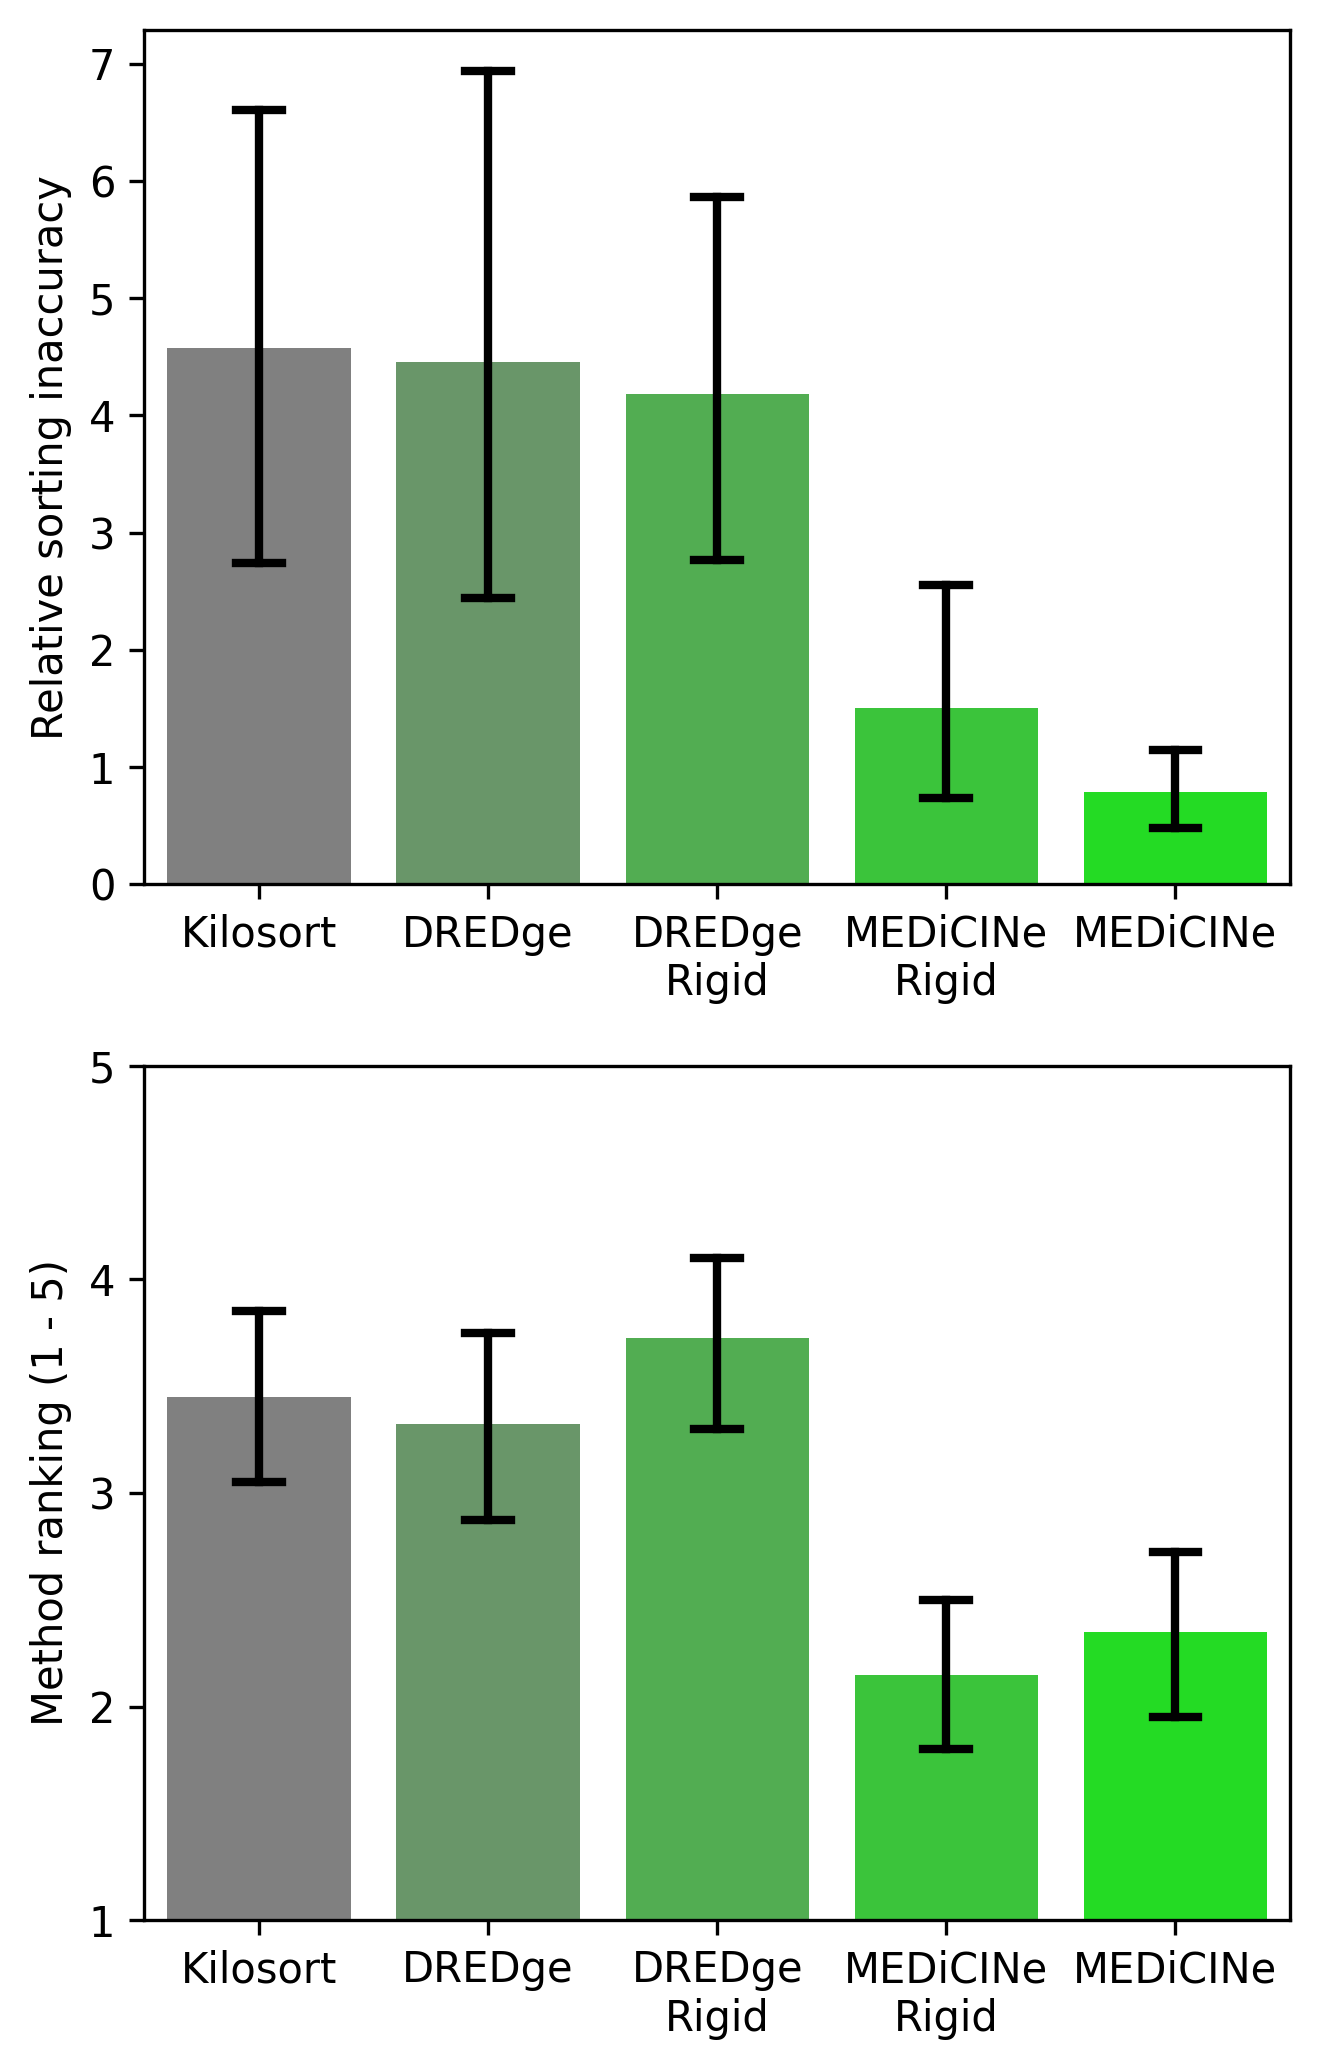

In [6]:
"""Make plot."""

fig, axes = plt.subplots(2, 1, figsize=(4.5, 7), dpi=300)

for ax, key in zip(axes, ['sum_accuracy_residual', 'method_ranking']):
    plot = sns.barplot(
        ax=ax,
        data=results_df,
        y=key,
        x='method',
        order=METHODS,
        hue='method',
        palette=PALETTE,
        hue_order=METHODS,
        legend=False,
        capsize=0.2,
        err_kws={'color': 'k', 'linewidth': 2},
    )
axes[0].set_ylabel('Relative sorting inaccuracy')
axes[1].set_ylabel('Method ranking (1 - 5)')
axes[1].set_ylim(1, len(METHODS))
axes[1].set_yticks(np.arange(1, len(METHODS) + 1))
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    ax.set_xticks([bar.get_x() + 0.5 * bar.get_width() for bar in ax.patches])
    ax.set_xticklabels([METHOD_NAMES[method] for method in METHODS], rotation=0)
    ax.set_xlabel('')
fig.tight_layout()